# Observable Household Characteristics and Poverty Level in Costa Rica


In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report,accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from utils import *

#### Ronald Bustamante Medina
CIMPA - Escuela de Matemática, UCR

 ![Kaggle](kaggle.jpg)

https://www.kaggle.com/c/costa-rican-household-poverty-prediction

### Inter-American Developement Bank

- Social aids are assigned according to poverty level

- Poverty level is determined by a means test which depends on income. This is in fact hard to achieve.

- Instead, a Proxy Means Test (PMT) is used. This is an algorithm that considers a household’s observable  attributes to infer their poverty level.

### Would it be possible to obtain better results with a Machine Learning classification model?

### Data

- From individuals (age, gender, education level, etc.)

- From household (number, female and male ratio, education mean, etc.)

- From the house (materials, number of rooms, rent, etc.)

- Goods (number of cellphones, number of tablets, etc.)

### Classes

1. Extreme poverty
2. Moderate poverty
3. Vulnerable
4. Non-vulnerable

In [2]:
dataset = pd.read_csv('./dataset.csv')
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
dataset.head()

,Id,rent,bedroomovercr,rooms,roomovercr,bath_in,refrig,tablet,num_tablets,r4h1,...,age_mean,age_std,age_min,age_max,age_sum,schoollevel_age_mean,schoollevel_age_std,schoollevel_age_min,schoollevel_age_max,schoollevel_age_sum
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,43.0,0.000000,43,43,43,0.232558,0.000000,0.232558,0.232558,0.232558
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,67.0,0.000000,67,67,67,0.179104,0.000000,0.179104,0.179104,0.179104
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,92.0,0.000000,92,92,92,0.119565,0.000000,0.119565,0.119565,0.119565
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,25.0,14.899664,8,38,100,0.341544,0.126943,0.249997,0.529409,1.366175
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,25.0,14.899664,8,38,100,0.341544,0.126943,0.249997,0.529409,1.366175


### Class distribution

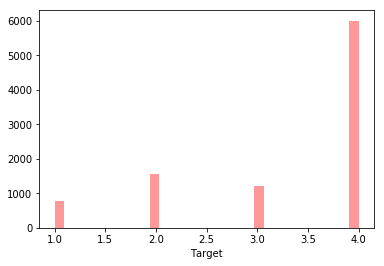

In [4]:
sns.distplot(dataset['Target'], kde=False, color="r")

#### Unbalanced

### To bear in mind

- In the dataset, there are individuals that belong to the same household.
- The inference is done based on the data of one individual.

### We are going to create a dataframe with the unique households and their targets.

In [5]:
# Which are the unique idhogar?
homeid_unique=dataset['homeid'].unique()
#Create a dataframe with the unique idhogar and its targets
targets=np.zeros(2988)

i=0
for home in homeid_unique:
    targets[i]=np.int(dataset[dataset['homeid']==home].Target.mean())
    i=i+1
    
home_unique = pd.DataFrame(data={'homeid': homeid_unique, 'Target': targets})
home_unique.tail(10)

,Target,homeid
2978,4.0,fef7fd222
2979,4.0,bb631bc5d
2980,4.0,2fa33aed8
2981,4.0,08908240a
2982,3.0,b58de0516
2983,1.0,9bbf7c6ca
2984,2.0,e87e70c06
2985,4.0,a8eeafc29
2986,2.0,212db6f6c
2987,2.0,d6c086aa3


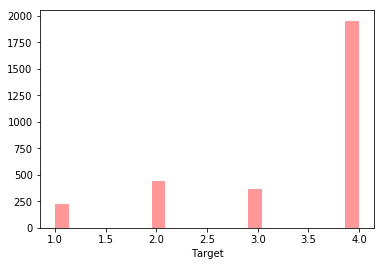

In [6]:
sns.distplot(home_unique['Target'], kde=False, color="r")

Still unbalanced

### Resampling

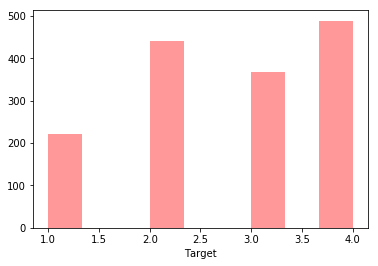

In [7]:
home_unique_sub=home_unique.drop(home_unique.query('Target == 4').sample(frac=.75).index)
sns.distplot(home_unique_sub['Target'], kde=False, color="r")

The chosen home indexes are:

In [8]:
home_indexes=home_unique_sub['homeid'].values

### Evaluation

Precision: 
$$\cfrac{VP}{VP+FP}$$

Recall:
$$\cfrac{VP}{VP+FN}$$

F1-score:

$$\cfrac{2}{pr^{-1}+ex^{-1}}$$

Macro: scores average

Micro: weighted scores average

### With 4 classes

### Feature selection

In [9]:
selected_columns_4_classes=feature_selection(dataset, home_indexes)
selected_columns_4_classes

Index(['rent', 'bedroomovercr', 'rooms', 'tablet', 'num_tablets', 'r4h1',
       'r4h2', 'r4m1', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'housesize',
       'schoollevel', 'hhsize', 'ceiling', 'children', 'adults', 'inhabitants',
       'dependency', 'maleheadeduc', 'femaleheadeduc', 'meaneduc', 'bedrooms',
       'overcrowding', 'computer', 'television', 'qmobilephone', 'SQBescolari',
       'SQBinhabitants', 'SQBmaleheadeduc', 'SQBchildren', 'SQBovercrowding',
       'SQBmeaned', 'floorstate', 'wallsstate', 'externalwalls', 'waste',
       'roofstate', 'floor', 'kitchen', 'educacationyears', 'child_ratio',
       'male_adult_man_ratio', 'human_density', 'human_bed_density',
       'rent_per_person', 'rent_per_room', 'mobile_per_person',
       'tablet_per_person', 'tablet_per_adult', 'overcr_rm+', 'num_elec',
       'schoollevel_mean', 'schoollevel_min', 'schoollevel_max',
       'schoollevel_sum', 'age_mean', 'schoollevel_age_mean',
       'schoollevel_age_min', 'Target', 'Id', 'homeid'],
 

In [10]:
dataset[selected_columns_4_classes].head()

,rent,bedroomovercr,rooms,tablet,num_tablets,r4h1,r4h2,r4m1,r4m3,r4t1,...,schoollevel_mean,schoollevel_min,schoollevel_max,schoollevel_sum,age_mean,schoollevel_age_mean,schoollevel_age_min,Target,Id,homeid
0,190000.0,0,3,0,0.0,0,1,0,0,0,...,10.00,10,10,10,43.0,0.232558,0.232558,4,ID_279628684,21eb7fcc1
1,135000.0,0,4,1,1.0,0,1,0,0,0,...,12.00,12,12,12,67.0,0.179104,0.179104,4,ID_f29eb3ddd,0e5d7a658
2,0.0,0,8,0,0.0,0,0,0,1,0,...,11.00,11,11,11,92.0,0.119565,0.119565,4,ID_68de51c94,2c7317ea8
3,180000.0,0,5,1,1.0,0,2,1,2,1,...,8.25,2,11,33,25.0,0.341544,0.249997,4,ID_d671db89c,2b58d945f
4,180000.0,0,5,1,1.0,0,2,1,2,1,...,8.25,2,11,33,25.0,0.341544,0.249997,4,ID_d56d6f5f5,2b58d945f


### Logistic Regression

In [11]:
LR = LogisticRegression(solver='liblinear',random_state=42, max_iter=3000, multi_class='auto')

#LR_model_1=LR.fit(X_train[selected_columns_1],Y_train)
reportLR=cross_validation(LR, dataset[selected_columns_4_classes], 4,home_indexes)

In [12]:
print_report(reportLR)

Class 1, precision: 0.5266569879984514
Class 1, recall: 0.13178182002010175
Class 1, F1: 0.20861344203327423
Class 2, precision: 0.41355717129858255
Class 2, recall: 0.6386141195521821
Class 2, F1: 0.5001414739981263
Class 3, precision: 0.3707769702824034
Class 3, recall: 0.1892181374223568
Class 3, F1: 0.24672025942056078
Class 4, precision: 0.5712057025190107
Class 4, recall: 0.6903381493366109
Class 4, F1: 0.6247250140205323
Macro Avg F1: 0.3950500473681234
Acc :0.46625715574541804


### Boosted Trees

#### XGBoost

In [13]:
xgbc=XGBClassifier(learning_rate=0.1, 
                      n_estimators=145, 
                      max_depth=3,
                        min_child_weight=3, gamma=0.05, subsample=0.6, colsample_bytree=1.0,
                        objective='multiclass:softmax', nthread=4, scale_pos_weight=1, seed=42)
        
reportXGB, imp_XGB_4 =cross_validation(xgbc, dataset[selected_columns_4_classes], 
                            4, home_indexes, importances=True)

In [14]:
print_report(reportXGB)

Class 1, precision: 0.408106350904443
Class 1, recall: 0.24565518318358315
Class 1, F1: 0.30186962242604654
Class 2, precision: 0.42473148204594063
Class 2, recall: 0.5556422495627912
Class 2, F1: 0.47827001613285763
Class 3, precision: 0.353270382070742
Class 3, recall: 0.2920704845931915
Class 3, F1: 0.31927874421715674
Class 4, precision: 0.6196863247505708
Class 4, recall: 0.6450897064524524
Class 4, F1: 0.6301184021508069
Macro Avg F1: 0.432384196231717
Acc :0.4666498206989072


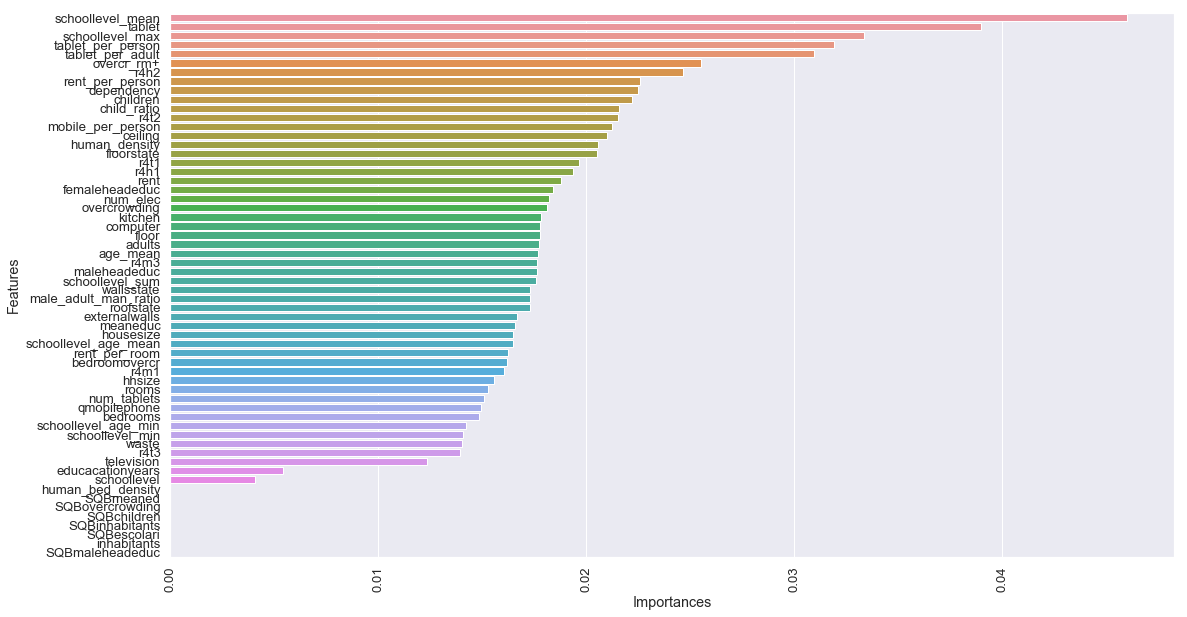

In [15]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=imp_XGB_4)
plt.xticks(rotation='vertical')
plt.show()

#### LightGBM

In [16]:
lgbm = lgb.LGBMClassifier(max_depth=2, learning_rate=0.01, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=-1, n_estimators=1145, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 20, num_leaves = 21, 
                          subsample = 0.96)
      
reportLGBM, imp_LGBM_4=cross_validation(lgbm, dataset[selected_columns_4_classes], 4, 
                                        home_indexes, importances=True)

In [17]:
print_report(reportLGBM)

Class 1, precision: 0.3531421423033842
Class 1, recall: 0.471540153064654
Class 1, F1: 0.40294608208908944
Class 2, precision: 0.41004273657205415
Class 2, recall: 0.3517719186759999
Class 2, F1: 0.37701375841233065
Class 3, precision: 0.3702411185483979
Class 3, recall: 0.36170135424197586
Class 3, F1: 0.3631340146285491
Class 4, precision: 0.6451050249608384
Class 4, recall: 0.631199682153151
Class 4, F1: 0.6374185022869951
Macro Avg F1: 0.44512808935424103
Acc :0.4547172784811499


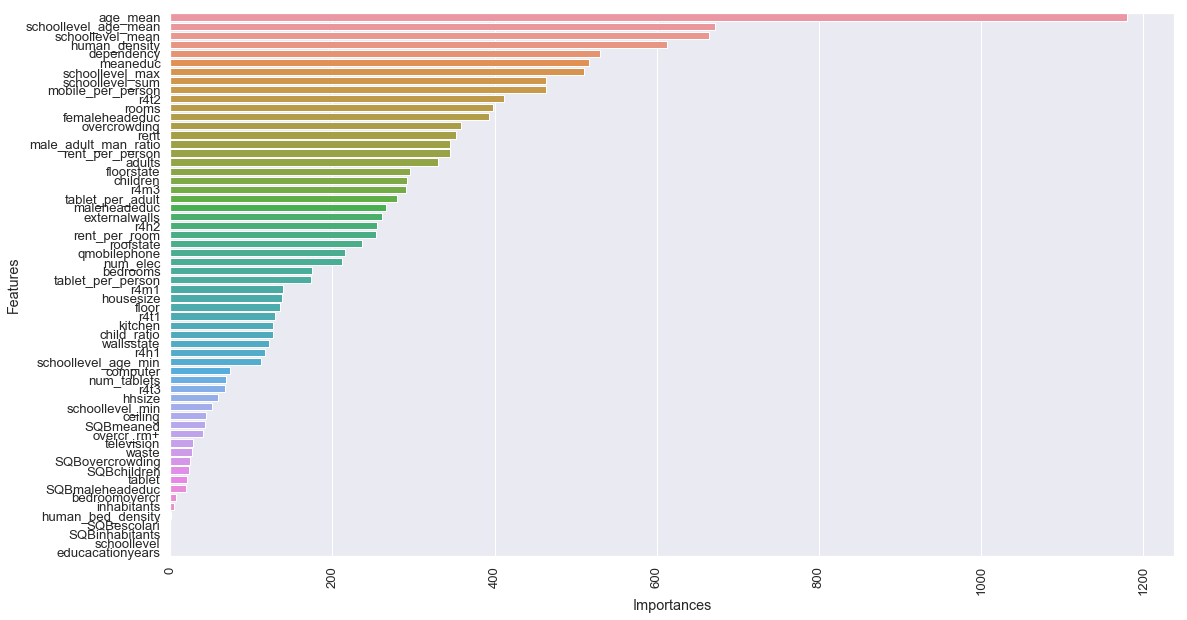

In [18]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=imp_LGBM_4)
plt.xticks(rotation='vertical')
plt.show()

### Random Forests

In [19]:
rfc = RandomForestClassifier(n_estimators=70, 
                                     criterion='gini',
                                     max_features='auto',
                                     max_depth=20)
reportRF, imp_RF_4=cross_validation(rfc, dataset[selected_columns_4_classes], 
                           4,home_indexes, importances=True)

In [20]:
print_report(reportRF)

Class 1, precision: 0.40200210281039983
Class 1, recall: 0.269849002624171
Class 1, F1: 0.3177472926846618
Class 2, precision: 0.4112198741185932
Class 2, recall: 0.5209137222879359
Class 2, F1: 0.4558077493700739
Class 3, precision: 0.3313145869760515
Class 3, recall: 0.2712186401127016
Class 3, F1: 0.2974271958711593
Class 4, precision: 0.6075746083770426
Class 4, recall: 0.6350369897947792
Class 4, F1: 0.6198140661283377
Macro Avg F1: 0.42269907601355816
Acc :0.4522319892940162


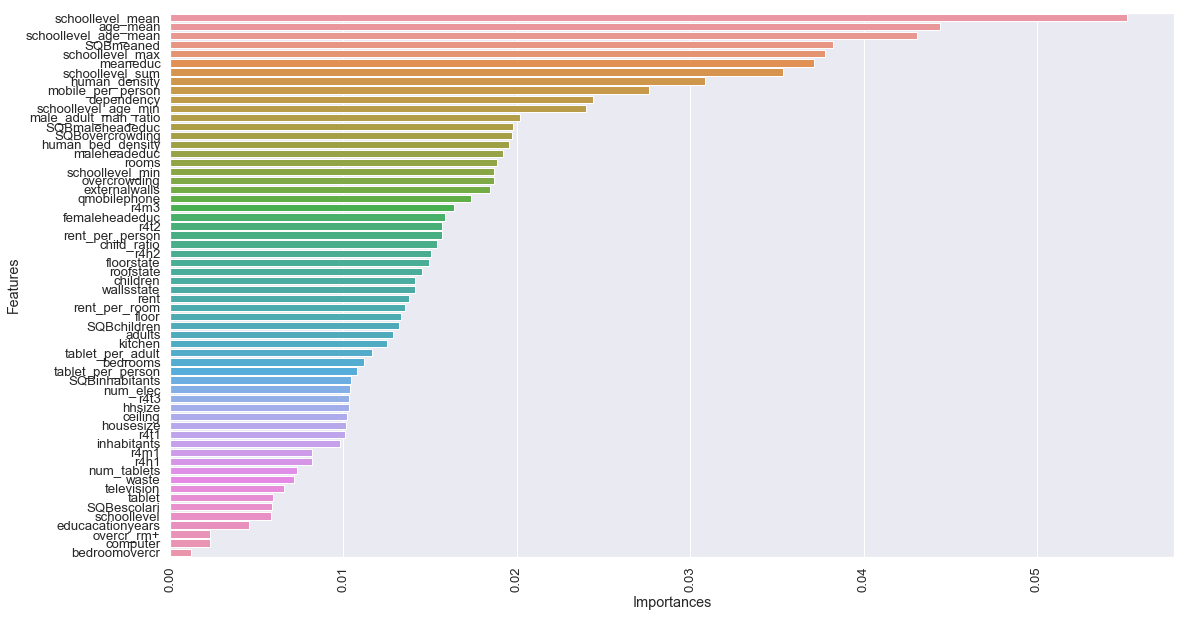

In [21]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=imp_RF_4)
plt.xticks(rotation='vertical')
plt.show()

### 2 classes

Now our aim is  to classify between class 1 and the rest.

1: Extreme poverty

2: The rest

In [22]:
dataset_2= dataset.copy()
dataset_2.loc[dataset_2.Target!=1, 'Target']=2
dataset_2.tail(10)

,Id,rent,bedroomovercr,rooms,roomovercr,bath_in,refrig,tablet,num_tablets,r4h1,...,age_mean,age_std,age_min,age_max,age_sum,schoollevel_age_mean,schoollevel_age_std,schoollevel_age_min,schoollevel_age_max,schoollevel_age_sum
9547,ID_198be48d1,46500.0,0,5,0,1,1,0,0.0,1,...,26.8,18.753666,2,46,134,0.252849,0.274549,0.0,0.611108,1.264245
9548,ID_9df63c33e,46500.0,0,5,0,1,1,0,0.0,1,...,26.8,18.753666,2,46,134,0.252849,0.274549,0.0,0.611108,1.264245
9549,ID_aacac04a2,46500.0,0,5,0,1,1,0,0.0,1,...,26.8,18.753666,2,46,134,0.252849,0.274549,0.0,0.611108,1.264245
9550,ID_90a399a51,0.0,0,3,0,1,1,0,0.0,0,...,64.0,4.242641,61,67,128,0.049180,0.069551,0.0,0.098360,0.098360
9551,ID_79d39dddc,0.0,0,3,0,1,1,0,0.0,0,...,64.0,4.242641,61,67,128,0.049180,0.069551,0.0,0.098360,0.098360
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,0.0,0,...,29.0,19.570386,2,50,145,0.219935,0.180650,0.0,0.423075,1.099677
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,0.0,0,...,29.0,19.570386,2,50,145,0.219935,0.180650,0.0,0.423075,1.099677
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,0.0,0,...,29.0,19.570386,2,50,145,0.219935,0.180650,0.0,0.423075,1.099677
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,0.0,0,...,29.0,19.570386,2,50,145,0.219935,0.180650,0.0,0.423075,1.099677
9556,ID_a38c64491,80000.0,0,6,0,1,1,0,0.0,0,...,29.0,19.570386,2,50,145,0.219935,0.180650,0.0,0.423075,1.099677


In [23]:
home_unique_2=home_unique.copy()
home_unique_2.loc[home_unique_2.Target!=1,'Target']=2
home_unique_2.tail(10)

,Target,homeid
2978,2.0,fef7fd222
2979,2.0,bb631bc5d
2980,2.0,2fa33aed8
2981,2.0,08908240a
2982,2.0,b58de0516
2983,1.0,9bbf7c6ca
2984,2.0,e87e70c06
2985,2.0,a8eeafc29
2986,2.0,212db6f6c
2987,2.0,d6c086aa3


We plot the unique household distribution:

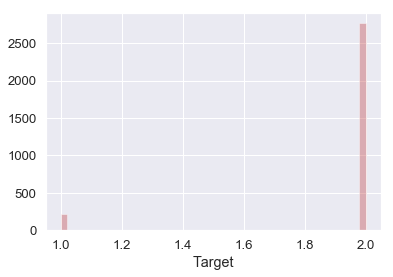

In [24]:
sns.distplot(home_unique_2['Target'], kde=False, color="r")

Let us resample

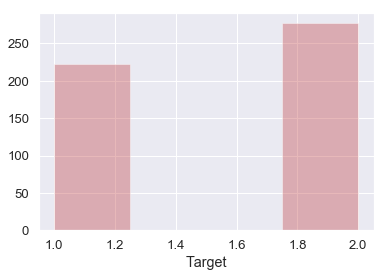

In [25]:
home_unique_2_sub=home_unique_2.drop(home_unique_2.query('Target == 2').sample(frac=.9).index)
sns.distplot(home_unique_2_sub['Target'], kde=False, color="r")

In [26]:
home_indexes_2=home_unique_2_sub['homeid'].values
dataset_2_sub=dataset_2[dataset_2['homeid'].isin(home_indexes_2)]

### Feature Selection

In [27]:
selected_columns_2_classes=feature_selection(dataset_2, home_indexes_2)
selected_columns_2_classes

Index(['rent', 'bedroomovercr', 'rooms', 'refrig', 'tablet', 'num_tablets',
       'r4h1', 'r4h2', 'r4m1', 'r4m3', 'r4t1', 'r4t2', 'schoollevel',
       'ceiling', 'children', 'adults', 'dependency', 'maleheadeduc',
       'meaneduc', 'bedrooms', 'overcrowding', 'computer', 'television',
       'qmobilephone', 'age', 'SQBescolari', 'SQBmaleheadeduc', 'SQBchildren',
       'SQBovercrowding', 'SQBmeaned', 'floorstate', 'wallsstate',
       'externalwalls', 'roofstate', 'floor', 'kitchen', 'region',
       'educacationyears', 'child_ratio', 'male_adult_man_ratio',
       'human_density', 'human_bed_density', 'rent_per_person',
       'rent_per_room', 'mobile_per_person', 'tablet_per_person',
       'tablet_per_adult', 'overcr_rm+', 'num_elec', 'schoollevel_age',
       'schoollevel_mean', 'schoollevel_min', 'schoollevel_max',
       'schoollevel_sum', 'age_mean', 'age_min', 'age_sum',
       'schoollevel_age_mean', 'schoollevel_age_min', 'schoollevel_age_sum',
       'Target', 'Id', 'home

### Logistic Regression

In [28]:
LR = LogisticRegression(solver='liblinear',random_state=42, max_iter=3000, multi_class='auto')
reportLR=cross_validation(LR, dataset_2[selected_columns_2_classes], 2,home_indexes_2)

In [29]:
print_report(reportLR)

Class 1, precision: 0.7299578724556094
Class 1, recall: 0.7077998338900221
Class 1, F1: 0.7175158582152992
Class 2, precision: 0.7536892871854995
Class 2, recall: 0.773995748180454
Class 2, F1: 0.7627407197612505
Macro Avg F1: 0.740128288988275
Acc :0.7425983381157341


#### Boosted Trees

#### XGBoost

In [30]:
xgbc=XGBClassifier(learning_rate=0.1, 
                      n_estimators=145, 
                      max_depth=3,
                        min_child_weight=3, gamma=0.05, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=42)
        
reportXGB, imp_XGB_2 =cross_validation(xgbc, dataset_2[selected_columns_2_classes], 
                            2, home_indexes_2, importances=True)

In [31]:
print_report(reportXGB)

Class 1, precision: 0.771097878677666
Class 1, recall: 0.7186814267157778
Class 1, F1: 0.7384197142625133
Class 2, precision: 0.7759099543626613
Class 2, recall: 0.8082220243857
Class 2, F1: 0.787950257870681
Macro Avg F1: 0.7631849860665971
Acc :0.768080000058575


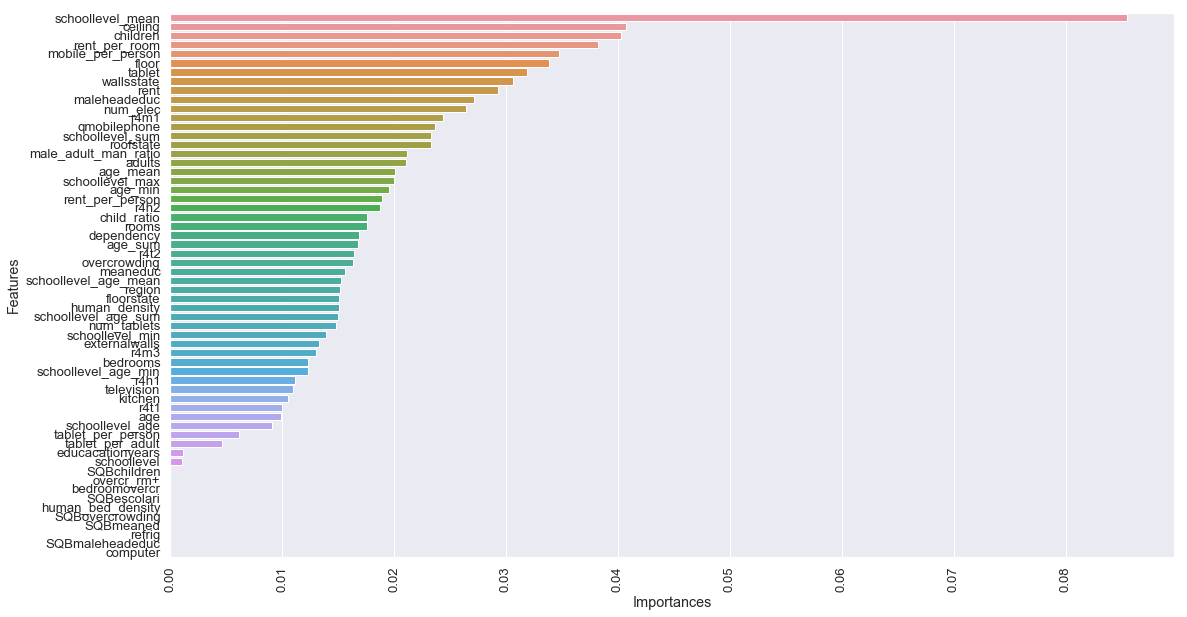

In [32]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=imp_XGB_2)
plt.xticks(rotation='vertical')
plt.show()

#### LightGBM

In [33]:
lgbm = lgb.LGBMClassifier(max_depth=2, learning_rate=0.01, objective='binary',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=-1, n_estimators=1145, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 20, num_leaves = 21, 
                          subsample = 0.96)
      
reportLGBM, imp_LGBM_2=cross_validation(lgbm, dataset_2[selected_columns_2_classes], 2, 
                                        home_indexes_2, importances=True)

In [34]:
print_report(reportLGBM)

Class 1, precision: 0.7039997952467804
Class 1, recall: 0.7476264590815674
Class 1, F1: 0.7241731929497615
Class 2, precision: 0.7784300331037489
Class 2, recall: 0.7331480820848724
Class 2, F1: 0.7540123545187717
Macro Avg F1: 0.7390927737342665
Acc :0.742692244491556


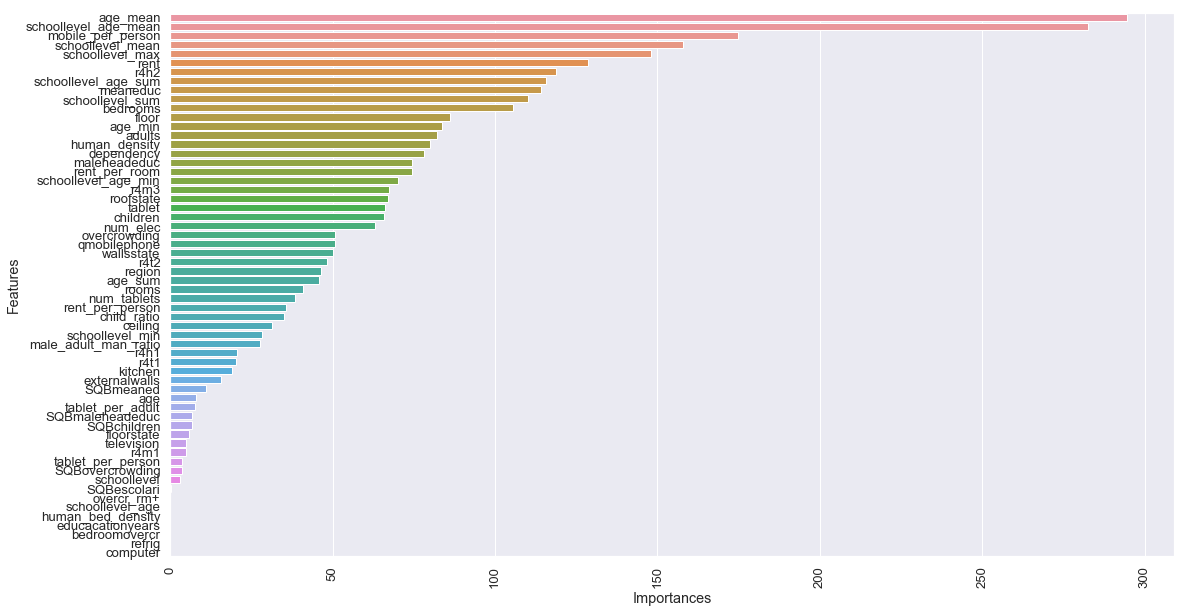

In [35]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=imp_LGBM_2)
plt.xticks(rotation='vertical')
plt.show()

### Random Forests

In [36]:
rfc = RandomForestClassifier(n_estimators=70, 
                                     criterion='gini',
                                     max_features='auto',
                                     max_depth=20)
reportRF, imp_RF_2=cross_validation(rfc, dataset_2[selected_columns_2_classes], 
                           2,home_indexes_2, importances=True)

In [37]:
print_report(reportRF)

Class 1, precision: 0.7034492226986002
Class 1, recall: 0.7365037795940295
Class 1, F1: 0.7167850161027609
Class 2, precision: 0.7667792977380927
Class 2, recall: 0.7353681587598376
Class 2, F1: 0.7485109966835477
Macro Avg F1: 0.7326480063931543
Acc :0.7344836173459361


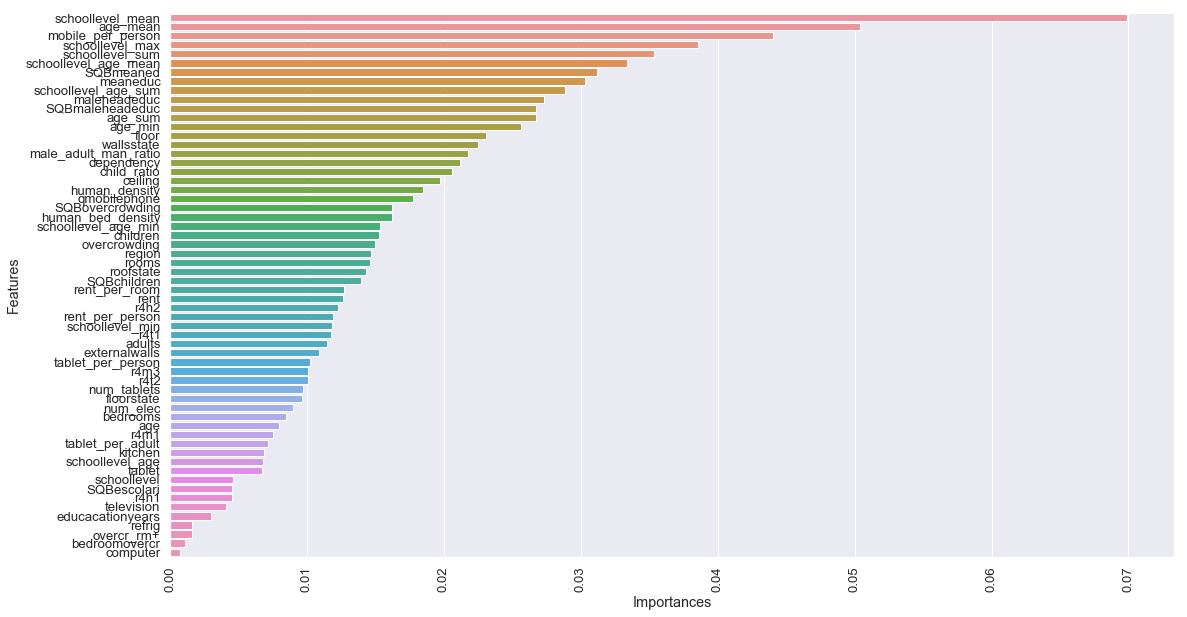

In [38]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=imp_RF_2)
plt.xticks(rotation='vertical')
plt.show()

Considering only two classes, we obtain better numbers (precision, recall, and F1) than for four classes. 
Perhaps institutions should use this approach if their interest is to determine an accurate way to assign aids to the poorest housholds.

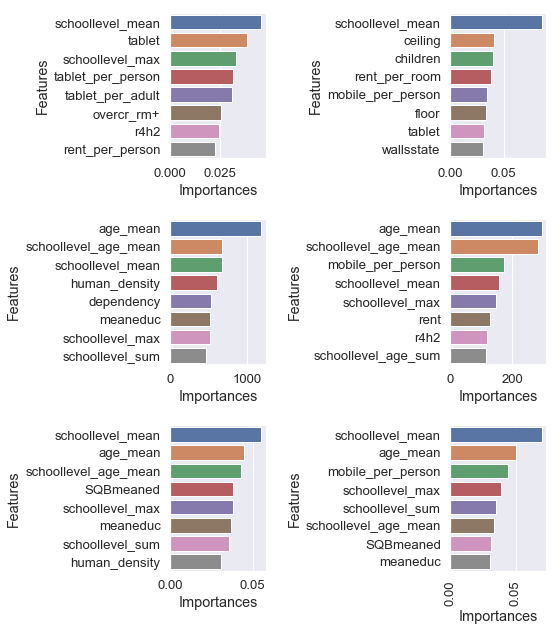

In [39]:
nr_rows = 3
nr_cols = 2



fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)

sns.barplot(x='Importances', y='Features', data=imp_XGB_4.head(8),ax = axs[0][0])
plt.xticks(rotation='vertical')

sns.barplot(x='Importances', y='Features', data=imp_XGB_2.head(8),ax = axs[0][1])
plt.xticks(rotation='vertical')

sns.barplot(x='Importances', y='Features', data=imp_LGBM_4.head(8),ax = axs[1][0])
plt.xticks(rotation='vertical')

sns.barplot(x='Importances', y='Features', data=imp_LGBM_2.head(8),ax = axs[1][1])
plt.xticks(rotation='vertical')

sns.barplot(x='Importances', y='Features', data=imp_RF_4.head(8),ax = axs[2][0])
plt.xticks(rotation='vertical')

sns.barplot(x='Importances', y='Features', data=imp_RF_2.head(8),ax = axs[2][1])
plt.xticks(rotation='vertical')
 
plt.tight_layout()    
plt.show()

We remark that in general, and more predominantly on the LightGBM and Random Forests models, the features related to education are of great importance. This, of course, does not necessarily mean that a good level of education reduces the chances for the household to fall into poverty, nor that only the less poor are able to obtain higher education levels.

#### Note:

Due to what we remarked above about several individuals belonging to the same household, we wrote some useful functions (in utils.py):

**fold**: creates k-folds from a dataset and its respective home index set.

**cross_validation**: performs cross validation of a model to a given dataset and its respective home index set. It outputs a report containing precision, recall, F1 and accuracy, and a feature importance dataframe.

**feature_selection**: selects features of a dataset, and its respective home indexe set, using the ANOVA F-value.



